## Method Testing: TE vs FreeSliders

This notebook now supports both FreeSliders and TE (Text Encoder) methods. You can switch between them by changing the `selected_method` variable in section 5.

**Methods Available:**
- **FreeSliders**: The original method that modifies latents during diffusion
- **TE**: Text Encoder method that interpolates embeddings during generation

**Default Scales:** [0, 1, 2, 3] - providing a good range from neutral to strong effects.

# Free Sliders Interactive Notebook - Text to Image (Stable Diffusion Backbone)

This notebook provides an easy-to-use interface for generating concept sliders using our method with Stable Diffusion and custom prompts.

## 1. Import Required Libraries

Import all necessary modules for the Free_Sliders pipeline.

In [56]:
import os
import sys
import warnings
import torch
import importlib
from datetime import datetime
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Suppress warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
)

# Import custom modules
from methods.FreeSliders import FreeSliders
from methods.TE import TE 
from utils.config_utils import load_config_from_yaml
from utils.prompt_utils import PromptSettings

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Configuration and Setup Logger

Load the default configuration and set up logging for the experiment.

In [57]:
# Load configuration
config_file = "configs/config.yaml"
config = load_config_from_yaml(config_file)

# Create a simple logger for notebook use
class NotebookLogger:
    def __init__(self):
        self.logs = {}
    
    def log_hparams(self, params):
        pass
    
    def add_tags(self, tag):
        pass
    
    def stop(self):
        pass
    
    def __getitem__(self, key):
        return self
    
    def log(self, value):
        pass

# Create logger and run ID for this session
run_id = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
logger = NotebookLogger()

print(f"Configuration loaded.")

Configuration loaded.


## 3. Load Pretrained Model

Load the Stable Diffusion model. This may take a few minutes on the first run.

In [58]:
# Load the base model
print("Loading Stable Diffusion model...")

module_name = "base_models.BaseModel_StableDiffusion"
BaseModelClass = importlib.import_module(module_name).BaseModel
base_model = BaseModelClass(config, run_id)

print("Model loaded successfully!")

Loading Stable Diffusion model...
Model loaded successfully!
Model loaded successfully!


## 4. Configure Prompts (Neutral, Positive, Negative)

Define your concept sliders by specifying:
- **Neutral**: Base prompt describing the subject
- **Positive**: What you want to enhance/add to the concept
- **Negative**: What you want to reduce/remove from the concept

**Examples:**
- Age slider: neutral="A person", positive="An old person", negative="A young person"
- Emotion slider: neutral="A person", positive="A smiling person", negative="A sad person"

In [59]:
# ===== CONFIGURE ALL PROMPTS FOR BATCH GENERATION =====

# Define all concept sliders to generate
concept_configs = [
    {
        "neutral": "A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic.",
        "positive": "A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic, smiling widely, very happy.",
        "negative": "A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, realistic background that outside with depth of field, photorealistic, frowning, very sad.",
        "tag": "smiling",
        "scales": [-2.0, -0.8, 0.0, 0.7, 1.4, 2.5, 4.0]  
    },
    {
        "neutral": "A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic.",
        "positive": "A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic, very old, aged, wrinkly.",
        "negative": "A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic, very young, clear skin.",
        "tag": "age", 
        "scales": [-2.0, 0.0, 4.8, 6.5, 7.2, 7.6, 8.0]  
    },
    {
        "neutral": "A natural realistic image of a car parked on a street.",
        "positive": "A natural realistic image of a car parked on a street, damaged, broken headlights, dented car, with scrapped paintwork.",
        "negative": "A natural realistic image of a car parked on a street, mint condition, brand new, shiny.",
        "tag": "damaged_car",
        "scales": [0.0, 2.3, 3.8, 5.2, 6.6, 8.0]  
    }
]

# Create prompt settings for all concepts
all_prompt_settings = []
for config in concept_configs:
    prompt_setting = PromptSettings(
        neutral=config["neutral"],
        positive=config["positive"], 
        negative=config["negative"],
        guidance_scale=9.0,
        resolution=512,
        batch_size=1,
        tag=config["tag"]
    )
    all_prompt_settings.append(prompt_setting)

print(f"Configured {len(concept_configs)} concept sliders")

Configured 3 concept sliders


## 5. Configure Generation Parameters and Method Selection

Set parameters for the generation process and choose between FreeSliders and TE methods.

In [60]:
# ===== MODIFY THESE PARAMETERS AS NEEDED =====

# Method selection: "FreeSliders" or "TE"
selected_method = "FreeSliders"  # Change this to "TE" to use Text Encoder method

# Number of sliders to generate for each concept
num_images = 1

# Timestep for intervention (when to start manipulating diffusion)
timestep_intervention = 15  # Lower = more effect, less structure; Higher = less effect, more structure

# Guidance scales
guidance_scale_neutral = 7.5  # CFG for neutral prompt
guidance_scale_variation = 1.0  # CFG for positive/negative prompts

# Random seed for reproducibility
seed1 = 100
seed2 = 200

print(f"Selected method: {selected_method}")

Selected method: FreeSliders


## 6. Run FreeSliders

Generate the concept sliders using FreeSliders method. This process will:
1. Encode the prompts into embeddings
2. Generate images with different scaling factors
3. Create the slider visualization

In [61]:
print("Starting FreeSliders generation...")

# Encode all prompt settings together
all_prompt_embeddings = base_model.encode_prompts(all_prompt_settings)
print(f"Encoded {len(all_prompt_embeddings)} prompt pairs")

# Clean up text encoder to save memory after encoding all prompts
base_model.delete_and_flush()
print("Text encoder cleaned up")

Starting FreeSliders generation...
Encoded 3 prompt pairs
Text encoder cleaned up
Text encoder cleaned up


In [62]:
# Create a function to display images in a row directly from the results
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def create_and_display_image_row(img_slider_dict, concept_tag, scales_order=None):
    """
    Create and display a horizontal row of images from the img_slider dictionary.
    
    Args:
        img_slider_dict: Dictionary mapping scale -> PIL Image
        concept_tag: String identifier for the concept
        scales_order: Optional list to specify the order of scales
    """
    if not img_slider_dict:
        print(f"No images found for '{concept_tag}'")
        return None
    
    # Sort scales if no specific order provided
    if scales_order is None:
        scales = sorted(img_slider_dict.keys())
    else:
        scales = [s for s in scales_order if s in img_slider_dict]
    
    if not scales:
        print(f"No valid scales found for '{concept_tag}'")
        return None
    
    # Get images in the specified order
    images = [img_slider_dict[scale] for scale in scales]
    
    # Create a horizontal concatenation of images
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)
    
    # Create the combined image
    combined_img = Image.new('RGB', (total_width, max_height), 'white')
    
    # Paste images side by side
    x_offset = 0
    for img in images:
        combined_img.paste(img, (x_offset, 0))
        x_offset += img.width
    
    # Display the combined image
    plt.figure(figsize=(15, 4))
    plt.imshow(combined_img)
    plt.axis('off')
    plt.title(f"Concept: {concept_tag} (Scales: {scales})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return combined_img

# Store results for later display
concept_results = {}

print("Image row display function created")

Image row display function created


## 7. Generate Individual Sliders

Generate sliders for each concept one by one, displaying results immediately.

In [63]:
# ===== CONCEPT 1: SMILING SLIDER =====
concept_idx = 0
config = concept_configs[concept_idx]
concept_tag = config["tag"]
scales = config["scales"]

print(f"Generating {concept_tag} slider using {selected_method} method...")

# Access the specific prompt embedding for this concept
prompt_embedding = all_prompt_embeddings[concept_idx]
text_embeddings = {"static": [prompt_embedding]}

# Initialize the selected method
if selected_method == "FreeSliders":
    method_model = FreeSliders(base_model)
elif selected_method == "TE":
    method_model = TE(base_model)
else:
    raise ValueError(f"Unknown method: {selected_method}")

# Prepare arguments for this concept with unique naming
class Args:
    def __init__(self, scales, tag, method):
        self.num_images = num_images
        self.t = timestep_intervention
        self.scales = scales
        self.guidance = guidance_scale_neutral
        self.guidance2 = guidance_scale_variation
        self.BaseModel = "T2I"
        self.concept_tag = tag  # Add concept tag for unique naming
        self.method = method  # Add method info

args = Args(scales, concept_tag, selected_method)

# Create prompts dictionary
prompts = {"static": [all_prompt_settings[concept_idx]]}

# Run the selected method and capture the results
try:
    results = method_model(
        args=args,
        text_embeddings=text_embeddings,
        prompts=prompts,
        seed=seed1,
        logger=logger,
    )
    print(f"Slider generation completed for '{concept_tag}' using {selected_method}")
    
    # Extract the img_slider from the log_and_evaluate results
    if results:
        if selected_method == "FreeSliders":
            slider_imgs, contextual_clip, positive_clip, negative_clip, lpips, img_slider = results
        else:  # TE method
            # TE method returns results directly from log_and_evaluate
            img_slider = results if isinstance(results, dict) else None
            
        if img_slider:
            concept_results[concept_tag] = {
                'img_slider': img_slider,
                'scales': scales,
                'method': selected_method
            }
            
            # Display the image row immediately
            create_and_display_image_row(img_slider, f"{concept_tag} ({selected_method})", scales)
    
except Exception as e:
    print(f"Error during generation: {str(e)}")
    import traceback
    traceback.print_exc()

# Clean up for next iteration
del method_model
del text_embeddings

Generating smiling slider using FreeSliders method...

Computing FreeSliders for - Tag: smiling
Neutral Prompt: A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic.
Positive Prompt: A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic, smiling widely, very happy.
Negative Prompt: A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, realistic background that outside with depth of field, photorealistic, frowning, very sad.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/rotemez/Free_Sliders/.venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rotemez/Free_Sliders/.venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/rotemez/Free_Sliders/.venv/lib64/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Slider generation completed for 'smiling' using FreeSliders
Slider generation completed for 'smiling' using FreeSliders


In [64]:
# ===== CONCEPT 2: AGE SLIDER =====
concept_idx = 1
config = concept_configs[concept_idx]
concept_tag = config["tag"]
scales = config["scales"]

print(f"Generating {concept_tag} slider using {selected_method} method...")

# Access the specific prompt embedding for this concept
prompt_embedding = all_prompt_embeddings[concept_idx]
text_embeddings = {"static": [prompt_embedding]}

# Initialize the selected method
if selected_method == "FreeSliders":
    method_model = FreeSliders(base_model)
elif selected_method == "TE":
    method_model = TE(base_model)
else:
    raise ValueError(f"Unknown method: {selected_method}")

# Prepare arguments for this concept
args = Args(scales, concept_tag, selected_method)

# Create prompts dictionary
prompts = {"static": [all_prompt_settings[concept_idx]]}

# Run the selected method and capture the results
try:
    results = method_model(
        args=args,
        text_embeddings=text_embeddings,
        prompts=prompts,
        seed=seed2,
        logger=logger,
    )
    print(f"Slider generation completed for '{concept_tag}' using {selected_method}")
    
    # Extract the img_slider from the log_and_evaluate results
    if results:
        if selected_method == "FreeSliders":
            slider_imgs, contextual_clip, positive_clip, negative_clip, lpips, img_slider = results
        else:  # TE method
            img_slider = results if isinstance(results, dict) else None
            
        if img_slider:
            concept_results[concept_tag] = {
                'img_slider': img_slider,
                'scales': scales,
                'method': selected_method
            }
            
            # Display the image row immediately
            create_and_display_image_row(img_slider, f"{concept_tag} ({selected_method})", scales)
    
except Exception as e:
    print(f"Error during generation: {str(e)}")
    import traceback
    traceback.print_exc()

# Clean up for next iteration
del method_model
del text_embeddings

Generating age slider using FreeSliders method...

Computing FreeSliders for - Tag: age
Neutral Prompt: A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic.
Positive Prompt: A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic, very old, aged, wrinkly.
Negative Prompt: A natural portrait photo of a person, upper body shot, captured with a high quality camera, realistic facial features, soft lighting, detailed clothing, background of a park with depth of field, photorealistic, very young, clear skin.
Running missing scales: [4.8, 6.5, 7.6]


Diffusing with scale 7.6: 100%|██████████| 35/35 [00:04<00:00,  7.93it/s]



Saved latents to T2I_sd_latents/FreeSliders/age/7.5/1.0/15/374.pkl
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/rotemez/Free_Sliders/.venv/lib64/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Loading model from: /home/rotemez/Free_Sliders/.venv/lib64/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Slider generation completed for 'age' using FreeSliders
Slider generation completed for 'age' using FreeSliders


In [65]:
# ===== CONCEPT 3: DAMAGED CAR SLIDER =====
concept_idx = 2
config = concept_configs[concept_idx]
concept_tag = config["tag"]
scales = config["scales"]

print(f"Generating {concept_tag} slider using {selected_method} method...")

# Access the specific prompt embedding for this concept
prompt_embedding = all_prompt_embeddings[concept_idx]
text_embeddings = {"static": [prompt_embedding]}

# Initialize the selected method
if selected_method == "FreeSliders":
    method_model = FreeSliders(base_model)
elif selected_method == "TE":
    method_model = TE(base_model)
else:
    raise ValueError(f"Unknown method: {selected_method}")

# Prepare arguments for this concept
args = Args(scales, concept_tag, selected_method)

# Create prompts dictionary
prompts = {"static": [all_prompt_settings[concept_idx]]}

# Run the selected method and capture the results
try:
    results = method_model(
        args=args,
        text_embeddings=text_embeddings,
        prompts=prompts,
        seed=seed1,
        logger=logger,
    )
    print(f"Slider generation completed for '{concept_tag}' using {selected_method}")
    
    # Extract the img_slider from the log_and_evaluate results
    if results:
        if selected_method == "FreeSliders":
            slider_imgs, contextual_clip, positive_clip, negative_clip, lpips, img_slider = results
        else:  # TE method
            img_slider = results if isinstance(results, dict) else None
            
        if img_slider:
            concept_results[concept_tag] = {
                'img_slider': img_slider,
                'scales': scales,
                'method': selected_method
            }
            
            # Display the image row immediately
            create_and_display_image_row(img_slider, f"{concept_tag} ({selected_method})", scales)
    
except Exception as e:
    print(f"Error during generation: {str(e)}")
    import traceback
    traceback.print_exc()

# Clean up for next iteration
del method_model
del text_embeddings

print(f"All concept sliders generation completed using {selected_method} method!")

Generating damaged_car slider using FreeSliders method...

Computing FreeSliders for - Tag: damaged_car
Neutral Prompt: A natural realistic image of a car parked on a street.
Positive Prompt: A natural realistic image of a car parked on a street, damaged, broken headlights, dented car, with scrapped paintwork.
Negative Prompt: A natural realistic image of a car parked on a street, mint condition, brand new, shiny.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/rotemez/Free_Sliders/.venv/lib64/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Loading model from: /home/rotemez/Free_Sliders/.venv/lib64/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Slider generation completed for 'damaged_car' using FreeSliders
All concept sliders generation completed using FreeSliders method!
Slider generation completed for 'damaged_car' using FreeSliders
All concept sliders g

## 8. View Generated Results

Display the generated concept sliders or view all results together.

Looking for sliders with concept tags: ['smiling', 'age', 'damaged_car']
Base seeds configured: seed1=100, seed2=200


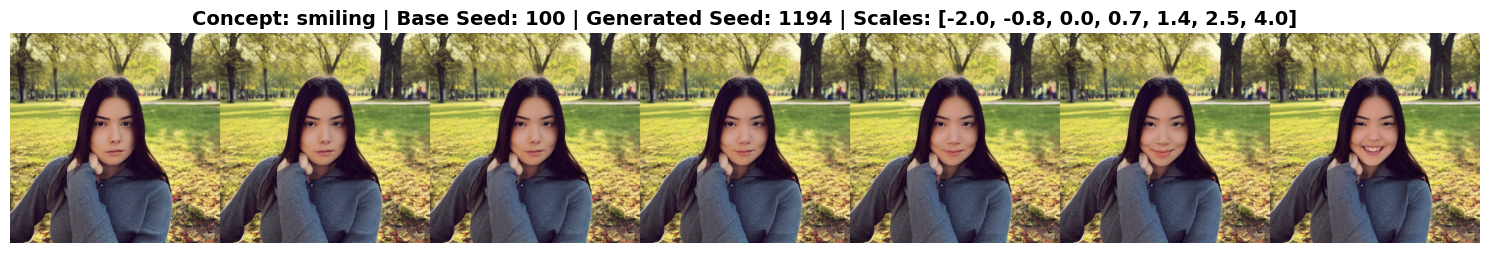

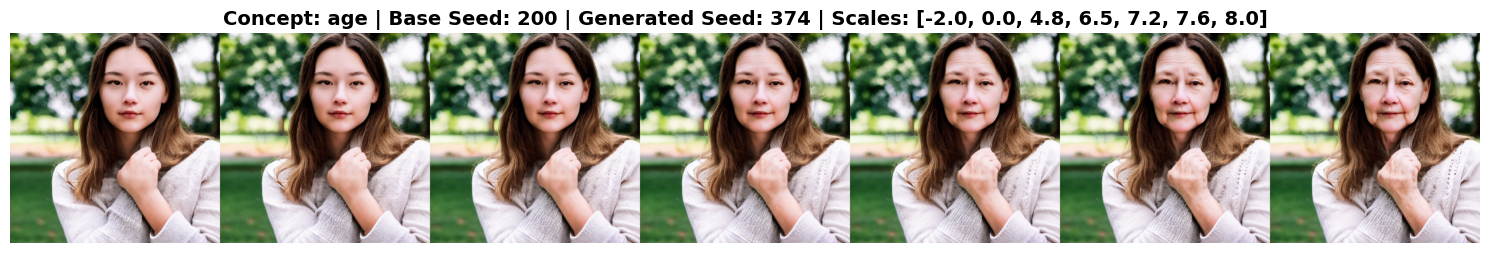

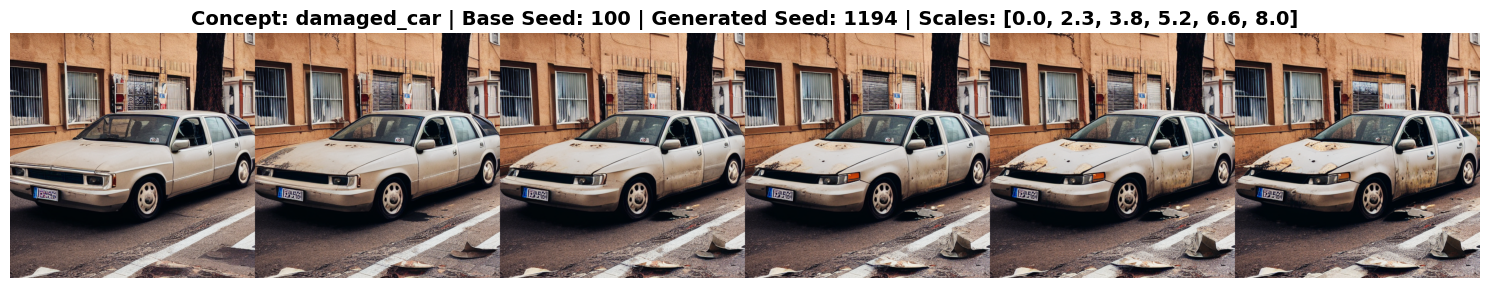

In [66]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

def load_and_display_configured_sliders():
    """Load and display sliders matching the configured concepts, seeds, and scales."""
    outputs_dir = "outputs"
    
    if not os.path.exists(outputs_dir):
        print("No outputs directory found")
        return
    
    # Get the concept tags from the configured prompts
    concept_tags = [config["tag"] for config in concept_configs]
    
    print(f"Looking for sliders with concept tags: {concept_tags}")
    print(f"Base seeds configured: seed1={seed1}, seed2={seed2}")
    
    for i, concept_config in enumerate(concept_configs):
        concept_tag = concept_config["tag"]
        expected_scales = concept_config["scales"]
        
        # Determine which base seed was used for this concept
        if i == 0:  # First concept uses seed1
            base_seed = seed1
        elif i == 1:  # Second concept uses seed2  
            base_seed = seed2
        else:  # Remaining concepts use seed1
            base_seed = seed1
        
        # Generate the actual seed that would be used (mimicking the generation process)
        random.seed(base_seed)
        generated_seeds = [random.randint(1, 5000) for _ in range(num_images)]
        actual_seed = generated_seeds[0]  # Take the first generated seed
            
        concept_path = os.path.join(outputs_dir, concept_tag)
        
        if not os.path.exists(concept_path):
            print(f"No directory found for concept '{concept_tag}'")
            continue
            
        # Look for the specific generated seed directory
        seed_dir_name = f"seed_{actual_seed}"
        seed_path = os.path.join(concept_path, seed_dir_name)
        
        if not os.path.exists(seed_path):
            print(f"No seed directory found for concept '{concept_tag}' with generated seed {actual_seed}")
            # Try to find any seed directory as fallback
            seed_dirs = [d for d in os.listdir(concept_path) if os.path.isdir(os.path.join(concept_path, d))]
            if seed_dirs:
                seed_path = os.path.join(concept_path, seed_dirs[0])
                actual_seed = seed_dirs[0].replace('seed_', '') if seed_dirs[0].startswith('seed_') else seed_dirs[0]
                print(f"Using fallback seed directory: {seed_dirs[0]}")
            else:
                continue
        
        # Find scale images matching the expected scales
        scale_info = []
        for scale in expected_scales:
            scale_file = os.path.join(seed_path, f"scale_{scale}.png")
            if os.path.exists(scale_file):
                scale_info.append((scale, scale_file))
            else:
                print(f"Missing scale file for {concept_tag} scale {scale}: {scale_file}")
        
        if not scale_info:
            print(f"No scale images found for concept '{concept_tag}'")
            continue
            
        # Sort by scale value to maintain order
        scale_info.sort(key=lambda x: x[0])
        
        # Load images in the specified scale order
        images = []
        scales = []
        for scale_val, img_file in scale_info:
            try:
                img = Image.open(img_file)
                images.append(img)
                scales.append(scale_val)
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
        
        if not images:
            print(f"Failed to load any images for concept '{concept_tag}'")
            continue
            
        # Create horizontal concatenation
        total_width = sum(img.width for img in images)
        max_height = max(img.height for img in images)
        
        combined_img = Image.new('RGB', (total_width, max_height), 'white')
        
        x_offset = 0
        for img in images:
            combined_img.paste(img, (x_offset, 0))
            x_offset += img.width
        
        # Display the slider
        plt.figure(figsize=(15, 4))
        plt.imshow(combined_img)
        plt.axis('off')
        plt.title(f"Concept: {concept_tag} | Base Seed: {base_seed} | Generated Seed: {actual_seed} | Scales: {scales}", 
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Load and display sliders matching the configured parameters
load_and_display_configured_sliders()